# Predicting Business Popularity
##### Pytorch Geometric implementation with NetworkX graph

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch_geometric.nn as pyg_nn

import networkx as nx
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating the network graph datasets

We use NetworkX to read and parse the graph into train/validate/test sets. We load these into DataLoader to use mini-batching.

In [4]:
G = nx.read_gpickle("./drive/MyDrive/Colab Notebooks/restaurants_MA.gpickle")

In [5]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 6192
Number of edges: 40605


In [6]:
H = Graph(G)
dataset = GraphDataset(graphs=[H], task='node')

In [7]:
print(dataset.graphs[0].node_feature)

tensor([[ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  9.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  0.0000, 16.0000,  0.8670],
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  3.0000,  1.0000],
        ...,
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000, 12.0000,  0.9700],
        [ 4.0000,  1.0000,  1.0000,  ...,  0.0000, 32.0000,  0.6390],
        [ 2.0000,  1.0000,  1.0000,  ...,  0.0000,  4.0000,  1.0000]])


In [8]:
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=16)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=16)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=16)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels
print(f"There are {num_node_features} features and {num_classes} labels.")

There are 59 features and 3 labels.


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the popularity category, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [9]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(num_node_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=59, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [10]:
x = dataset.graphs[0].node_feature
y = dataset.graphs[0].node_label

print(x.size())
print(y.size())

torch.Size([6192, 59])
torch.Size([6192])


In [11]:
import numpy as np

mask = np.random.rand(1, y.size()[0])

train_mask = (mask < 0.9)[0]
test_mask = (mask >= 0.9)[0]

print(train_mask)
print(test_mask)

[ True False  True ...  True  True  True]
[False  True False ... False False False]


In [12]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(x)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 500):
    loss = train()
    if epoch % 5 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 005, Loss: 1.0713
Epoch: 010, Loss: 1.0397
Epoch: 015, Loss: 1.0125
Epoch: 020, Loss: 0.9901
Epoch: 025, Loss: 0.9721
Epoch: 030, Loss: 0.9551
Epoch: 035, Loss: 0.9505
Epoch: 040, Loss: 0.9342
Epoch: 045, Loss: 0.9353
Epoch: 050, Loss: 0.9242
Epoch: 055, Loss: 0.9239
Epoch: 060, Loss: 0.9173
Epoch: 065, Loss: 0.9108
Epoch: 070, Loss: 0.9111
Epoch: 075, Loss: 0.9092
Epoch: 080, Loss: 0.8967
Epoch: 085, Loss: 0.8994
Epoch: 090, Loss: 0.8966
Epoch: 095, Loss: 0.8994
Epoch: 100, Loss: 0.8901
Epoch: 105, Loss: 0.9019
Epoch: 110, Loss: 0.8969
Epoch: 115, Loss: 0.8904
Epoch: 120, Loss: 0.8914
Epoch: 125, Loss: 0.8950
Epoch: 130, Loss: 0.8866
Epoch: 135, Loss: 0.8901
Epoch: 140, Loss: 0.8882
Epoch: 145, Loss: 0.8857
Epoch: 150, Loss: 0.8938
Epoch: 155, Loss: 0.8870
Epoch: 160, Loss: 0.8851
Epoch: 165, Loss: 0.8820
Epoch: 170, Loss: 0.8849
Epoch: 175, Loss: 0.8844
Epoch: 180, Loss: 0.8830
Epoch: 185, Loss: 0.8861
Epoch: 190, Loss: 0.8833
Epoch: 195, Loss: 0.8787
Epoch: 200, Loss: 0.8836


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [13]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5794


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


In [14]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        conv_model = self.build_conv_model(args["model"])
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_size, hidden_size))

        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        elif model_type == "TransformerConv":
            return pyg_nn.TransformerConv
        else:
            raise ValueError(
                "Model {} unavailable, please add it to GNN.build_conv_model.".format(model_type))

In [22]:
def train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-5)
    losses = []
    accuracies = [[], [], []] # train / validate / test

    for epoch in range(1, args['epochs']+1):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test_gnn(train_loader, model, device)
        val_acc = test_gnn(val_loader, model, device)
        test_acc = test_gnn(test_loader, model, device)

        if epoch % 5 == 0:
          print(f"Epoch {epoch}: Train: {train_acc:.4f}, Validation: {val_acc:.4f}. Test: {test_acc:.4f}, Loss: {total_loss:.4f}")

        losses.append(round(total_loss, 4))
        accuracies[0].append(train_acc)
        accuracies[1].append(val_acc)
        accuracies[2].append(test_acc)

    return (model, losses, accuracies)

def test_gnn(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

In [23]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 250})'''))

args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 64,
    "epochs" : 250,
    "lr" : 0.01,
    "num_layers": 2,
    "model": "GraphSage" # [GraphSage, GAT, GCN, TransformerConv]
}

gnn_model, losses, accuracies = train_gnn(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])

<IPython.core.display.Javascript object>

GNN(
  (convs): ModuleList(
    (0): SAGEConv(59, 64)
    (1): SAGEConv(64, 64)
  )
  (post_mp): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 5: Train: 0.3959, Validation: 0.4023. Test: 0.4065, Loss: 1.6049
Epoch 10: Train: 0.4973, Validation: 0.4863. Test: 0.4468, Loss: 1.2992
Epoch 15: Train: 0.5358, Validation: 0.5477. Test: 0.4968, Loss: 1.1070
Epoch 20: Train: 0.5377, Validation: 0.5832. Test: 0.5048, Loss: 1.0268
Epoch 25: Train: 0.5480, Validation: 0.5913. Test: 0.5048, Loss: 0.9846
Epoch 30: Train: 0.5692, Validation: 0.5977. Test: 0.5113, Loss: 0.9562
Epoch 35: Train: 0.5694, Validation: 0.5670. Test: 0.4919, Loss: 0.9448
Epoch 40: Train: 0.5873, Validation: 0.6010. Test: 0.5177, Loss: 0.9310
Epoch 45: Train: 0.5855, Validation: 0.5994. Test: 0.5210, Loss: 0.9124
Epoch 50: Train: 0.5891, Validation: 0.5961. Test: 0.5242, Loss: 0.9038
Epoch 55: Train: 0.5920, Validation: 0.6074. Test: 0.5258, Loss: 0.9038
Epoch 60: Train: 0.6019, Validation: 0.5961. Test: 0.5242, L

### Plotting training data 

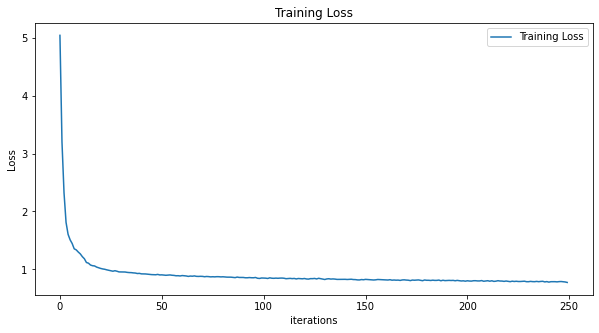

In [24]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses, label="Training Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

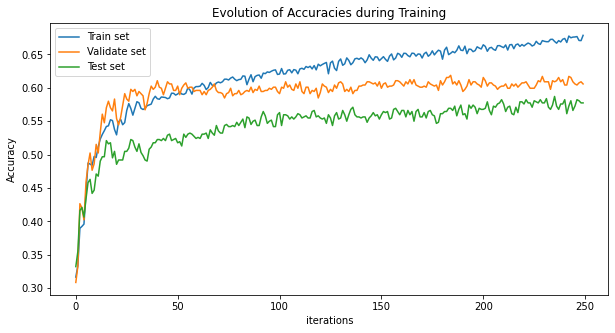

In [25]:
plt.figure(figsize=(10,5))
plt.title("Evolution of Accuracies during Training")
plt.plot(accuracies[0],label="Train set")
plt.plot(accuracies[1],label="Validate set")
plt.plot(accuracies[2],label="Test set")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Report

In [26]:
final_test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=len(dataset_test))

y_pred = None
y_true = None

gnn_model.eval()
for batch in final_test_loader:
    batch.to("cuda")
    logits = gnn_model(batch)
    y_pred = logits[batch.node_label_index].max(1)[1]
    y_true = batch.node_label

In [27]:
from sklearn.metrics import classification_report

target_names = ['Low', 'Middle', 'High']
print(classification_report(y_true.cpu(), y_pred.cpu(), target_names=target_names))

              precision    recall  f1-score   support

         Low       0.66      0.73      0.69       223
      Middle       0.46      0.43      0.44       216
        High       0.60      0.57      0.59       181

    accuracy                           0.58       620
   macro avg       0.57      0.58      0.57       620
weighted avg       0.57      0.58      0.57       620



In [28]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_true.cpu(), y_pred.cpu())

array([[[312,  85],
        [ 60, 163]],

       [[295, 109],
        [124,  92]],

       [[371,  68],
        [ 78, 103]]])